# TMDB 电影数据分析

本文中用到的数据文件：tmdb_5000_movies.csv、tmdb_5000_credits.csv是Kaggle平台上的项目TMDB(The Movie Database)，共计4803部电影，主要为美国地区一百年间（1916-2017）的电影作品。

本文通过对电影数据的分析，利用数据可视化的方法，发现流行趋势，找到投资方向，为本行业新入局者提供一定参考建议。同时也为了提升自己的数据分析能力，在遇到类似项目可以触类旁通。

**主要包括一下几个部分**:
- 数据预处理
- 特征提取
- 特征选取
- 数据可视化

In [1]:
import os
import numpy as np
import pandas as pd
import json
from wordcloud import wordcloud
import matplotlib.pyplot as plt
%matplotlib inline

## 1- 问题陈述

官网的问题描述地址（https://www.kaggle.com/tmdb/tmdb-movie-metadata/home).

从电影市场趋势，受众喜好，电影票房等三个方面主要研究以下几个问题：

- 各类型电影数量分布及随时间变化趋势如何？
- 不同类型电影的盈利能力如何？
- 原创电影与改编电影有何差异？
- 电影大多产自什么地方？
- 电影关键字分析
- 受众喜好与那些因素有关？
- Universal Pictures与Paramount Pictures两家行业巨头的业绩如何？
- 电影票房与哪些因素最相关？


## 2-查看数据

从Kaggle平台上下载2个原始数据集：tmdb_5000_movies.csv和tmdb_5000_credits.csv，movies存放电影的基本信息，credits存放电影的演职员名单。相关字段含义介绍：

| 左对齐标题 | 右对齐标题 | 居中对齐标题 |
| ------| ------ | ------ |
| 短文本 | 中等文本 | 稍微长一点的文本 |
| 稍微长一点的文本 | 短文本 | 中等文本 |

                   
·title : 电影名称
·cast ：演员列表  
·director ：导演
·budget ：预算（美元）
·genres ：电影类型
·homepage ：电影首页的 URL
·id ：标识号
·original_language ：电影语言
·original_title ：电影名称
·overview ：剧情摘要
·popularity ：在 Movie Database 上的相对页面查看次数
·production_companies ：制作公司
·production_countries ：制作国家
·release_date ：上映时间
·revenue ：票房收入
·runtime ：电影时长
·spoken_languages ：口语
·status ：状态
·tagline ：电影的标语
·vote_average ：平均评分
 ·vote_count ：评分次数

In [2]:
# 加载数据
credits = pd.read_csv('data/tmdb_5000_credits.csv')
movies = pd.read_csv('data/tmdb_5000_movies.csv')
#credits.head()
#movies.head()

# credits 和 movies 中都有title 字段，删除其中一个
del credits['title']
# 做链接方式合并数据
total = pd.merge(movies,credits,left_on='id', right_on='movie_id', how='left')
# 不需要字段
drop_title=['homepage','id','original_language','original_title','overview','spoken_languages','status','tagline','movie_id','cast','crew']
total.drop(drop_title,axis=1,inplace=True)

我们看一下合并完之后的数据信息，先查看一下shape和第一行信息：

In [3]:
print(total.shape)
# 查看第一行信息
print(total.ix[0])

(4803, 12)
budget                                                          237000000
genres                  [{"id": 28, "name": "Action"}, {"id": 12, "nam...
keywords                [{"id": 1463, "name": "culture clash"}, {"id":...
popularity                                                        150.438
production_companies    [{"name": "Ingenious Film Partners", "id": 289...
production_countries    [{"iso_3166_1": "US", "name": "United States o...
release_date                                                   2009-12-10
revenue                                                        2787965087
runtime                                                               162
title                                                              Avatar
vote_average                                                          7.2
vote_count                                                          11800
Name: 0, dtype: object


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


release_date列有1条缺失数据，将其查找出来并填充：

In [4]:
total[total.release_date.isnull()]

,budget,genres,keywords,popularity,production_companies,production_countries,release_date,revenue,runtime,title,vote_average,vote_count
4553,0,[],[],0.0,[],[],NaN,0,0.0,America Is Still the Place,0.0,0


In [5]:
total.release_date = total.release_date.fillna('2014-06-01')

runtime列有2条缺失数据，将其查找出来并填充：

In [6]:
total[total.runtime.isnull()]

,budget,genres,keywords,popularity,production_companies,production_countries,release_date,revenue,runtime,title,vote_average,vote_count
2656,15000000,"[{""id"": 18, ""name"": ""Drama""}]","[{""id"": 717, ""name"": ""pope""}, {""id"": 5565, ""na...",0.738646,"[{""name"": ""Taodue Film"", ""id"": 45724}]","[{""iso_3166_1"": ""IT"", ""name"": ""Italy""}]",2015-12-03,0,NaN,Chiamatemi Francesco - Il Papa della gente,7.3,12
4140,2,"[{""id"": 99, ""name"": ""Documentary""}]","[{""id"": 6027, ""name"": ""music""}, {""id"": 225822,...",0.050625,"[{""name"": ""Eyeline Entertainment"", ""id"": 60343}]","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2015-12-12,0,NaN,"To Be Frank, Sinatra at 100",0.0,0


In [7]:
total.runtime=total.runtime.fillna(94,limit=1)
total.runtime=total.runtime.fillna(240,limit=1)

对于release_date列，需将其转换为日期类型并提取出年份，并查看处理结果:

In [8]:
total.release_date=pd.to_datetime(total.release_date,format='%Y-%m-%d',errors='coerce').dt.year
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 12 columns):
budget                  4803 non-null int64
genres                  4803 non-null object
keywords                4803 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4803 non-null int64
revenue                 4803 non-null int64
runtime                 4803 non-null float64
title                   4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 647.8+ KB


## 2-特殊格式数据处理

本项目要进行研究的数据中的genres，keywords，production_companies，production_countries列均为json格式，不便对其进行分析。需先导入json（开始已操作），再通过json.loads先将json字符串转换为字典列表形式，再使用循环，选取需要的数据，本次分析取出name键所对应的值，并用“|”分隔。


In [9]:
json_column = ['genres','keywords','production_companies','production_countries']
for column in json_column:
    total[column] = total[column].map(json.loads)
def getName(x):
    name = []
    for item in x:
        name.append(item['name'])
    return '|'.join(name)
for column in json_column:
    total[column] = total[column].map(getName)

In [10]:
total.head(2)

,budget,genres,keywords,popularity,production_companies,production_countries,release_date,revenue,runtime,title,vote_average,vote_count
0,237000000,Action|Adventure|Fantasy|Science Fiction,culture clash|future|space war|space colony|so...,150.437577,Ingenious Film Partners|Twentieth Century Fox ...,United States of America|United Kingdom,2009,2787965087,162.0,Avatar,7.2,11800
1,300000000,Adventure|Fantasy|Action,ocean|drug abuse|exotic island|east india trad...,139.082615,Walt Disney Pictures|Jerry Bruckheimer Films|S...,United States of America,2007,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500


## 3-数据分析和可视化

### 3-1-各电影类型数量分布及随时间变化趋势如何

先找到所有电影类型，并存放到genre_set集合中：

In [12]:
genre_set = set()
for item in total['genres']:
    genre_set.update(item.split('|'))
genre_set.discard('')
print("genres num: %d" % len(genre_set))

genres num: 20


构造电影类型和年份的数据框：

In [17]:
genre_df = pd.DataFrame()
for genre in genre_set:
    genre_df[genre] = total['genres'].str.contains(genre).map(lambda x: 1 if x else 0)
genre_df['release_date']=total['release_date']
genre_by_year = genre_df.groupby('release_date').sum()
genre_by_year.tail(2)


,Action,Mystery,Science Fiction,War,Family,Romance,Fantasy,Comedy,Adventure,Documentary,TV Movie,History,Music,Thriller,Horror,Foreign,Crime,Animation,Drama,Western
release_date,,,,,,,,,,,,,,,,,,,,
2016,39,6,11,3,9,9,13,26,23,0,0,6,1,27,20,0,10,4,37,1
2017,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


绘图显示

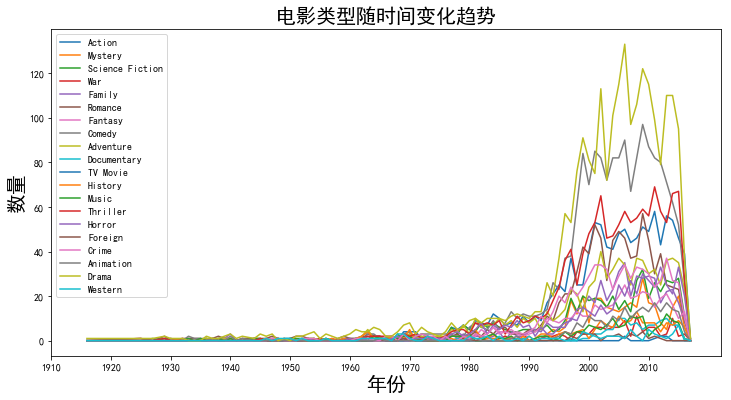

In [18]:
def showGenreYeas(genre_by_year):
    plt.rcParams['font.sans-serif']=['SimHei']
    fig = plt.figure(figsize=(12,6))
    plt.plot(genre_by_year,label=genre_by_year.columns)
    plt.legend(genre_by_year)
    plt.title("电影类型随时间变化趋势",fontsize=20)
    plt.xticks(range(1910,2018,10))
    plt.xlabel("年份",fontsize=20)
    plt.ylabel("数量",fontsize=20)
    plt.show()
showGenreYeas(genre_by_year)

各电影类型数量和：

In [19]:
genre_sum = genre_by_year.sum(axis=0).sort_values(ascending=True)
genre_sum

TV Movie              8
Foreign              34
Western              82
Documentary         110
War                 144
Music               185
History             197
Animation           234
Mystery             348
Fantasy             424
Family              513
Horror              519
Science Fiction     535
Crime               696
Adventure           790
Romance             894
Action             1154
Thriller           1274
Comedy             1722
Drama              2297
dtype: int64

绘图显示各类电影数量的对比：

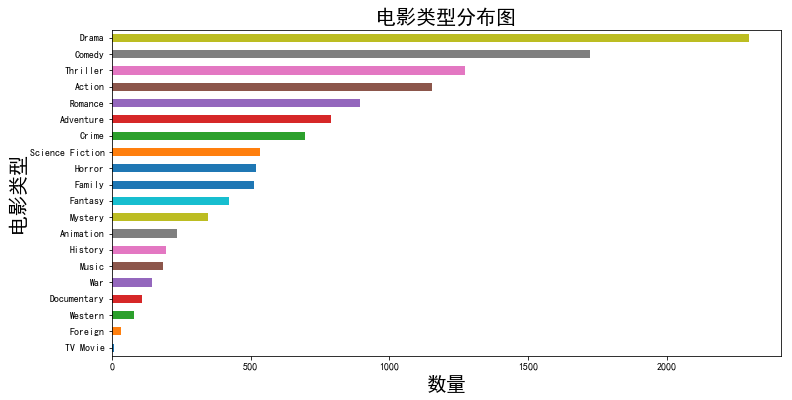

In [21]:
def showGenSum(genre_sum):
    plt.rcParams['font.sans-serif'] = ['SimHei']
    genre_sum.plot.barh(label='genre',figsize=(12,6))
    plt.title("电影类型分布图",fontsize=20)
    plt.xlabel("数量",fontsize=20)
    plt.ylabel("电影类型",fontsize=20)
    plt.show()
showGenSum(genre_sum)

由图可知，数量前5的电影类型为：戏剧类（Drama）、喜剧类（Comedy）、惊悚类（Thriller）、动作类（Action）、冒险类（Adventure）

### 3-2-不同类型电影的盈利能力如何